# Adversarial Robustness using AdverTorch BlackBox Estimators

We have previously introduced Advertorch [link to blog post], which is a toolbox for adversarial robustness research. As part of our initiative at Borealis AI to create a platform for model validation, we have been building more tools to validate the robustness of various machine learning models and visuals to make it easy for developers to understand the results.

In this tutorial, we will go through how Advertorch can be used to assess the robustness of any given ML model using the newly added blackbox estimators. These estimators allow you to use the toolbox for any type of model regardless of the deep learning framework used to develop them in the first place. 

Overall the tutorial will cover the following;

- Definition of what we mean by adversarial robustness
- How to use AdverTorch to create a blackbox gradient estimator
- How to use AdverTorch to find adversarial examples
- Methods for interpreting and visualizing the results

## Adversarial Robustness

Should there be a link to a paper here or is it safe to provide the definition we normally use? 

## Dataset and Model

For this tutorial we will be using the breast cancer dataset which is available through `sklearn`. It's a classic dataset for a binary classification task. The features describe various mesurements of the cell nuclei from a digitized image of a breast scan and the output indicates whether the mass is malignant or benign. The dataset is relatively small with only 569 samples and 30 features but it is sufficient for the purpose of tutorial. It's also suitable for this tutorial since it does not contain any categorical features.

In [142]:
# TODO: Delete this. Look into being able to run this from a colab notebook. 
import sys
import warnings
sys.path.append('../')
warnings.filterwarnings(action='ignore', module="sklearn")

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
tree_model = XGBClassifier(n_estimators=50)
tree_model.fit(X_train, y_train)
print("Accuracy: ", accuracy_score(tree_model.predict(X_test), y_test))

Accuracy:  0.9210526315789473


## Blackbox model

In order to perform attacks and find adversarial examples, we will use the newly added blackbox gradient estimators. As the name suggests, these estimators allow us to perform blackbox attacks where we might not have access to the gradients of the models or where the model simply does not have gradients (such as tree based models). All that is needed to construct a blackbox estimator is the `predict` function of the model which returns the class probabilities and an activation function.

Note that, one big disadvantage of this approach is that it is computationally quite heavy. While iteratively searching for advarsarial examples, we will need to perform gradient estimation calculations repeatedly. Moreover, search will likely take longer since the estimated gradients will not be as accurate as they would be in the case of a whitebox test. 

In [143]:
from advertorch.attacks.blackbox import NESWrapper, FDWrapper
import torch.nn as nn

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

activation = LambdaLayer(lambda x: x)
predict_fcn = lambda x: torch.from_numpy(tree_model.predict_proba(x))
pred_fcn = FDWrapper(func=predict_fcn, fd_eta=5.0)
bb_estimator = nn.Sequential(pred_fcn, activation)

## Statement

Now we build our statement. As mentioned previously, we are assessing the robustness for a classifcation task. Our decision statement in this case is to find whether there exists $x'{\in}Ball(x, \epsilon)$ such that $F(x') {\neq} y$.

To this end, we check wheter a given couter-example, $x'$, is inside our neighbourhood $Ball(x, \epsilon)$, and that $F(x') != y$. If both conditions are met, then the given couter-example example passes our decision statement. 

In [144]:
class RobustClassification:
    """For all inputs in a given neighbourhood, check if the model predicts the
    same class (according to argmax)"""
    def __init__(self, neighbourhood, model):
        self.neighbourhood = neighbourhood
        self.model = model

    def pred(self, x):
        with torch.no_grad():
            y = self.model(x).argmax(-1)
        return y

    def eval_input(self, X, Xprime, epsilon):
        return self.neighbourhood(Xprime, X) <= epsilon

    def eval_output(self, Y, Yprime):
        return Y != Yprime

    def eval_counterexample(self, X, Xprime, epsilon):
        valid_input = self.eval_input(X, Xprime, epsilon)
        Y, Yprime = self.pred(X), self.pred(Xprime)
        invalid_output = self.eval_output(Y, Yprime)
        return valid_input & invalid_output

## Neighbourhood

Now we construct the neighbourhood which allows us to check wether a given adversarial example lies within the constraints we would like to impose. For this tutorial, we will be using a scaled L-inf norm constraint. For each counter-example, we will check if the following condition holds;

$$ \forall x' \; | \; {\| x - x' \|}_\infty < \epsilon \land x_{min} < x' < x_{max} $$

Since we're using an infinity norm, the $\epsilon$ ball is really a rectangle. To ensure that the counter example lies within, we also need to scale our features, i.e. normalize the data points, or equivalently scale the $\epsilon$ according to feature range. To do this, we construct a dictionary containing all the necessary information for each of the features such as, the valid input range, scale, feature name and feature type ("REAL", "BIN" or "INT"). There is also a flag to tell the solver to ignore a given feature. This will allow for selecting the features we want to perturb as well as ignoring the ones we cannot perturb. The valid input range allows us to build a conditional mask to enforce validity of the generated counter-examples. Features that are outside of the valid range are masked, and thus not perturbed.



In [145]:
data_config = []

for i in range(len(dataset.feature_names)):
    data_config.append(
        {
            "Feature": dataset.feature_names[i],
            "Feature_type": "REAL",
            "ignore": False,
            "ranges": [min(dataset.data[i]), max(dataset.data[i])],
            "scales": max(dataset.data[i]) - min(dataset.data[i]),
        }
    )

In [146]:
import torch
from typing import Tuple, List, Dict
from advertorch.utils import clamp as batch_clamp

class ScaledLinfNeighbourhood(nn.Module):

    def __init__( self, config: List[Dict]):
        nn.Module.__init__(self)
        self.set_scales(config)

    def __call__(self, x1: torch.FloatTensor, x2: torch.FloatTensor) -> torch.FloatTensor:
        z1, z2 = self.transform(x1), self.transform(x2)
        return (abs(z1 - z2)).max(-1)[0]

    def set_scales(self, config: List[Dict]):
        n_dim = len(config)
        mins, maxs, intmask, ignore = (torch.zeros(n_dim) for _ in range(4))
        scales = torch.ones(n_dim)

        for i, feature in enumerate(config):
            if not feature["ignore"]:
                mins[i], maxs[i] = feature["ranges"]
                scales[i] = feature["scales"]

            intmask[i] = feature["Feature_type"] in ["BIN", "INT"]
            ignore[i] = feature["ignore"]

        self.register_buffer("mins", mins)
        self.register_buffer("maxs", maxs)
        self.register_buffer("scales", scales)
        self.register_buffer("intmask", intmask.bool())
        self.register_buffer("ignore", ignore.bool())

    def bounds(self, x: torch.FloatTensor, eps: torch.FloatTensor):
        outlier_mask = (x < self.mins) | (x > self.maxs)
        mask = outlier_mask | self.ignore
        eps_max = torch.min(x + eps[:, None] * self.scales, self.maxs)
        eps_min = torch.max(x - eps[:, None] * self.scales, self.mins)
        bmin = mask * x + ~mask * eps_min - 1e-9
        bmax = mask * x + ~mask * eps_max + 1e-9

        return bmin, bmax

    def transform(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return (x - self.mins) / self.scales

    def inverse_transform(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x * self.scales + self.mins

    def project(self, x: torch.FloatTensor, bounds) -> torch.FloatTensor:
        # Clamp to Linf Ball
        bmin, bmax = bounds
        batch_clamp(x, bmin, bmax)

        # Fix integers
        f, c = torch.floor(x), torch.ceil(x)
        floor_check = (f >= bmin) & (f <= bmax)
        rounded = torch.where(floor_check, f, c).float()

        x = torch.where(self.intmask.bool(), rounded, x)

        return x

## Solver

We use Projected Gradient Descent (PGD) to search for points in the input space which violate a statement of behaviour. These points are obtained from the original dataset using small perturbations, and are found by optimizing a surrogate loss (corresponding to the statement). We use the `perturb_iterative` function which is found in `advertorch`. It's a shared method for iterative attacks including `LinfPGD` which is what we will be using. We chose PGD for it's simlicity, the same idea could be extended to other solvers.

In [147]:
from advertorch.attacks.iterative_projected_gradient import perturb_iterative

class LinfPGDSolver:
    def __init__(self, statement, loss = nn.CrossEntropyLoss(reduction="sum")):
        self.statement = statement
        self.loss = loss
        self.model = self.build_model()

    def build_model(self):
        decoder = LambdaLayer(lambda x: self.decode(x))
        return nn.Sequential(decoder, self.statement.model)

    @property
    def neighbourhood(self):
        return self.statement.neighbourhood

    def encode(self, x: torch.FloatTensor):
        return self.neighbourhood.transform(x)

    def decode(self, x: torch.FloatTensor):
        return self.neighbourhood.inverse_transform(x)

    def _get_clip_bounds(self, X: torch.FloatTensor, eps: torch.FloatTensor) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        bmin, bmax = self.neighbourhood.bounds(X, eps)
        bmin, bmax = self.encode(bmin), self.encode(bmax)
        return bmin, bmax

    def generate_counterexamples(
        self, X: torch.FloatTensor, Y: torch.Tensor, linf_eps = 0.2, linf_eps_iter = 0.0625, linf_nb_iter = 500
    ) -> torch.FloatTensor:
        n_batch, _ = X.shape
        linf_eps = linf_eps * X.new_ones((n_batch,))
        bmin, bmax = self._get_clip_bounds(X, linf_eps)
        Xe = self.encode(X)
        adv = perturb_iterative(
            xvar=Xe,
            yvar=Y,
            predict=self.model,
            nb_iter=linf_nb_iter,
            eps=linf_eps,
            eps_iter=linf_eps_iter,
            loss_fn=self.loss,
            minimize=False,
            clip_min=bmin,
            clip_max=bmax,
        ).detach()

        adv, bmin, bmax = self.decode(adv), self.decode(bmin),self.decode(bmax)
        adv = self.neighbourhood.project(adv, (bmin, bmax))

        return adv

## Search for Adversarial Examples

Finally, we perform a binary search to find the best counter example, i.e counter example that satisfy all our constraints with smallest perturbation. We search for the best adversarial examples for a fixed number of iterations. Number of iterations in our binary search algorithm, number of iterations that we use for PGD solver and the number of samples we use for gradient estimators, countribute to the overall complexity of our test. Readers should be mindful when setting these values to ensure the adversarial examples are found wihtin a reasonable time frame. 

In [148]:
neighbourhood = ScaledLinfNeighbourhood(data_config)
statement = RobustClassification(neighbourhood, bb_estimator)
solver = LinfPGDSolver(statement=statement)

In [149]:
def binary_search_over_param(
    X: torch.Tensor,
    Y: torch.Tensor,
    statement,
    solver,
    init_val: float = 0.1,
    min_val: float = 0.0,
    max_val: float = 1.0,
    max_bin_iter: int = 5,
    seed: int = 0,
    params_for_solver: dict = {},
) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    torch.manual_seed(seed)
    n_batch, _ = X.shape
    cur_min = X.new_full((n_batch,), min_val)
    cur_max = X.new_full((n_batch,), max_val)
    cur_val = X.new_full((n_batch,), init_val)
    best_adv = torch.zeros_like(X)
    solver_dict = dict(params_for_solver)
    for i in range(max_bin_iter):
        solver_dict['linf_eps'] = cur_val
        adv = solver.generate_counterexamples(X, Y, **solver_dict)
        violations = statement.eval_counterexample(X, adv, cur_val)
        best_adv[violations] = adv[violations]
        cur_min = torch.where(violations, cur_min, cur_val)
        cur_max = torch.where(violations, cur_val, cur_max)
        cur_val = (cur_min + cur_max) / 2
    return best_adv, cur_max

best_adv, best_eps = binary_search_over_param(
    X=torch.Tensor(X_test),
    Y=torch.LongTensor(y_test),
    statement=statement,
    solver=solver,
    max_bin_iter=10,
    seed=0,
    params_for_solver = {
        'linf_eps_iter':0.0625,
        'linf_nb_iter':100
    }
)

## Understanding the Results

Now that we have our adversarial examples, we would like to evaluate them. We show couple of plots that might be useful in understanding how robust a given model is. However, it is important to note that robustness is not quantifiable. We do not provide any concrete metric as a measurement of robustness. We rather attempt to provide some insight that might be useful to the reader. They can be used in isolation but they're way more insightful when doing comparisons between two models or throughout the model development phase. 

### Flip Rate vs Epsilon Size

Epsilon size is the amount of perturbation required to generate a counterexample. The mean epsilon size is the average of all epsilon sizes found during the adv example search. The higher the mean epsilon size, the higher the robustness is. This value is best interpreted in comparison to competing models rather than in isolation. 

Flip rate is the rate of the test dataset that we were able to find adversarial examples for, i.e. flip the label from 0 to 1, or 1 to 0. It is useful to see how the flip rate changes as the size of the epsilon ball changes. It is also useful to see how samples from different labels perform. In this toy example, we see that samples from negative samples (y=0) are slightly less robust compared to the positive samples (y=1). Depending on the application and the metric being used for performance of the model, this might be important.

Flip Rate is 0.8333333134651184%.
Mean epsilon size is 0.047843337059020996.


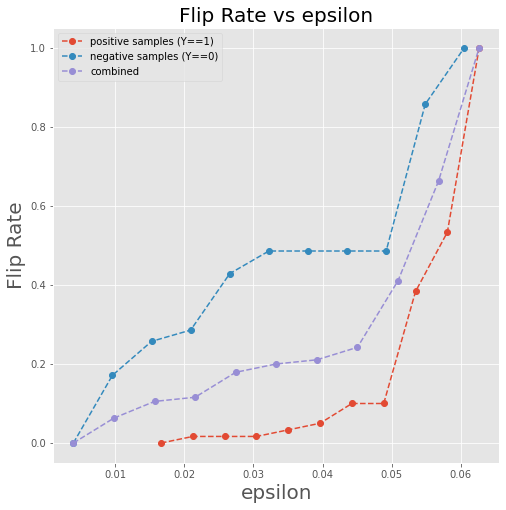

In [150]:
import matplotlib.pyplot as plt
# Compute mean epsilon
y_prob = tree_model.predict_proba(X_test)[:, 1]
y_prob_best_adv = tree_model.predict_proba(best_adv)[:, 1]
threshold = 0.5

idx = best_eps != 1.0
print(f'Flip Rate is {sum(idx)/len(best_eps)}%.')
print(f'Mean epsilon size is {best_eps[idx].mean()}.')

def cumulative_dist_plot(x, bins, ax, **kwargs):
    values, base = np.histogram(x, bins=bins)
    cumulative = np.insert(np.cumsum(values), 0, 0.0)
    cumulative = cumulative / cumulative[-1]
    return ax.errorbar(base, cumulative, **kwargs)

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_config = {'bins':10, 'ax':ax, 'marker':'o', 'linestyle':'--'}
cumulative_dist_plot(best_eps[(torch.Tensor(y_test)==1) & idx].cpu().numpy(), label='positive samples (Y==1)', **plot_config)
cumulative_dist_plot(best_eps[(torch.Tensor(y_test)==0) & idx].cpu().numpy(), label='negative samples (Y==0)', **plot_config)
cumulative_dist_plot(best_eps[idx].cpu().numpy(), label='combined', **plot_config)

plt.legend()
plt.xlabel('epsilon', fontsize=20)
plt.ylabel('Flip Rate', fontsize=20)
plt.title('Flip Rate vs epsilon', fontsize=20)
plt.show()

### Initial vs Perturbed Score
In this plot, we try to understand how succesfull the attack was in flipping the output label. We generate a color coded scatter plot, where each point corresponds to a sample. The coordinates of the point tells us what the model prediction for the original sample and for the corresponding counter-example. 

The points in the upper left corner and lower right corner are of particular interest to the users. These are the points that were originally predicted with a strong probability score and now being labelled with the opposite label with a strong probability score. The colour of the points are also important as it indicates the epsilon size. The points with lower epsilon sizes are more concerning than others as it means these can be quite sensitive to perturbations. 

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


Text(0.5, 1.0, 'Initial Prediction Score vs Perturbed Prediction Score')

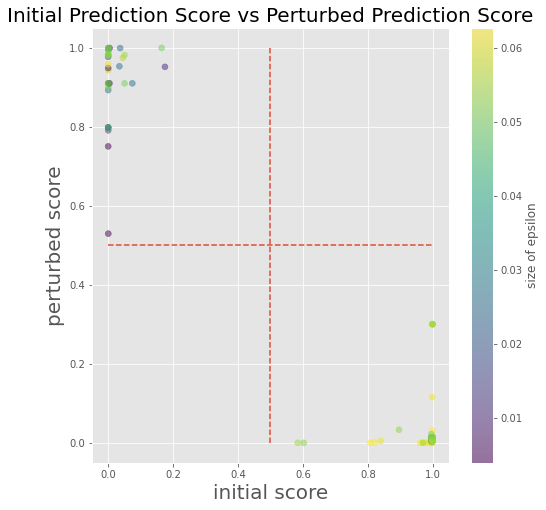

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

sc = ax.scatter(x=y_prob[idx], 
                y=y_prob_best_adv[idx], 
                c=best_eps[idx],
                alpha=0.5)

cbar = plt.colorbar(sc)
cbar.set_label('size of epsilon', fontsize=12)
plt.xlabel('initial score', fontsize=20)
plt.ylabel('perturbed score', fontsize=20)

plt.hlines(0.5, 0, 1, linestyles="--")
_ = plt.vlines(0.5, 0, 1, linestyles="--")
plt.title('Initial Prediction Score vs Perturbed Prediction Score', fontsize=20)

### Out of Distribution Check

Lastly, we investigate whether the counter-examples found in the attack allign with the original dataset. If there is a significant difference from the original dataset, the counter examples might not be of much concern as they might be detected by outlier detectors. For this tutorial, we will use Isolation Forest to see if any of our counter-examples are detected as an outlier. 

In [152]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest().fit(X_test)
print(f'{sum(clf.predict(best_adv) == 1)} samples detected as outliers')

0 samples detected as outliers


In addition, we will use the [Proxy-A Distance](https://papers.nips.cc/paper/2983-analysis-of-representations-for-domain-adaptation)(PAD) as a metric to measure how the adversarial example distribution shifts from original data points. To do this, we train a new model to distinguish original data from the adversarial examples. We combine the test dataset with the adversarial examples, create output labels where the samples from the original dataset are labelled as 0 and the adversarial examples are labelled as 1. Then we train an XGBoost classifier to distingues the two. Finally we get the MAE score on our test set and compute the PAD measure as $1-2*{MAE}$. The lower the PAD score, the closer two datasets are.

In [153]:
from sklearn.metrics import mean_absolute_error

x_adv = best_adv[idx]
y_prob_threshold = 0.5

# Train auxiliary model to classify adversarial examples.
# Combine the datasets
x_comb = np.r_[x_adv, X_test]
y_comb = np.r_[np.ones(x_adv.shape[0]), np.zeros(X_test.shape[0])]
x_comb_train, x_comb_test, y_comb_train, y_comb_test = train_test_split(x_comb, y_comb, train_size=0.7)
# Train a simple XGBoost classifier
model = XGBClassifier(n_estimators=5).fit(x_comb_train, y_comb_train)

# Compute MAE on test set
y_pred = [1-prob[0] for prob in model.predict_proba(x_comb_test)]
mae = mean_absolute_error(np.array(y_pred), y_comb_test)

# Compute Proxy-A distance
proxy_a_score = 1 - 2*mae

print(f'Proxy-A distance: {proxy_a_score}')

Proxy-A distance: 0.7646977787926084
